In [3]:
import numpy as np
from sklearn.manifold import TSNE
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os
from prettytable import PrettyTable
sns.set_theme()
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# [1] Reading data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Reviewsdf = pd.read_csv('gdrive/My Drive/Colab Notebooks/AI assignment/AI-assignment Folder/Reviews.csv')
Reviewsdf.head()

Mounted at /content/gdrive


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Dataset Claims

568,454 reviews  
256,059 users  
74,258 products  
260 users with > 50 reviews  
Reviews from Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10

In [ ]:

import time

Data = PrettyTable()
Data.field_names = ["Attribute","Claim","Actual","Match"]
Data.add_rows(
    [
        ["Number of reviews", "568454",Reviewsdf.shape[0],"YES"],
        ["Distinct users", "256059", Reviewsdf["UserId"].nunique(), "YES"],
        ["Distinct products", "74258", Reviewsdf["ProductId"].nunique(), "YES"],
        ["Users with more than 50 reviews", "260", (Reviewsdf.groupby("UserId").size()).where(lambda x:x>50).count(), "YES"],
        ["Reviews Time Range", "Oct 1999 - Oct 2012", f"{time.strftime('%b %Y', time.localtime(Reviewsdf['Time'].min()))} - {time.strftime('%b %Y', time.localtime(Reviewsdf['Time'].max()))}", "YES"]
    ]
)
print(Data)
Reviewsdf_shape = Reviewsdf.shape
print(f"No. of Datapoints : {Reviewsdf_shape[0]}")
print(f"No. of Features : {Reviewsdf_shape[1]}")

+---------------------------------+---------------------+---------------------+-------+
|            Attribute            |        Claim        |        Actual       | Match |
+---------------------------------+---------------------+---------------------+-------+
|        Number of reviews        |        568454       |        568454       |  YES  |
|          Distinct users         |        256059       |        256059       |  YES  |
|        Distinct products        |        74258        |        74258        |  YES  |
| Users with more than 50 reviews |         260         |         260         |  YES  |
|        Reviews Time Range       | Oct 1999 - Oct 2012 | Oct 1999 - Oct 2012 |  YES  |
+---------------------------------+---------------------+---------------------+-------+
No. of Datapoints : 568454
No. of Features : 10


## Attribute Information

1. **Id** - Row Id
2. **ProductId** - Unique identifier for the product
3. **UserId** - Unqiue identifier for the user
4. **ProfileName** - Profile name of the user
5. **HelpfulnessNumerator** - Number of users who found the review helpful
6. **HelpfulnessDenominator** - Number of users who indicated whether they found the review helpful or not
7. **Score** - Rating between 1 and 5
8. **Time** - Timestamp for the review
9. **Summary** - Brief summary of the review
10. **Text** - Text of the review  

<img src="https://nycdsa-blog-files.s3.us-east-2.amazonaws.com/2016/04/AmazonReview-300x189.png" width="600" height="400">

### Objective: 

#### Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).
   
> How to determine if a review is positive or negative?

We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# 2 Exploratory data Analysis

## Data cleaning
#### Check for missing values

In [ ]:
Reviewsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
Reviewsdf.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

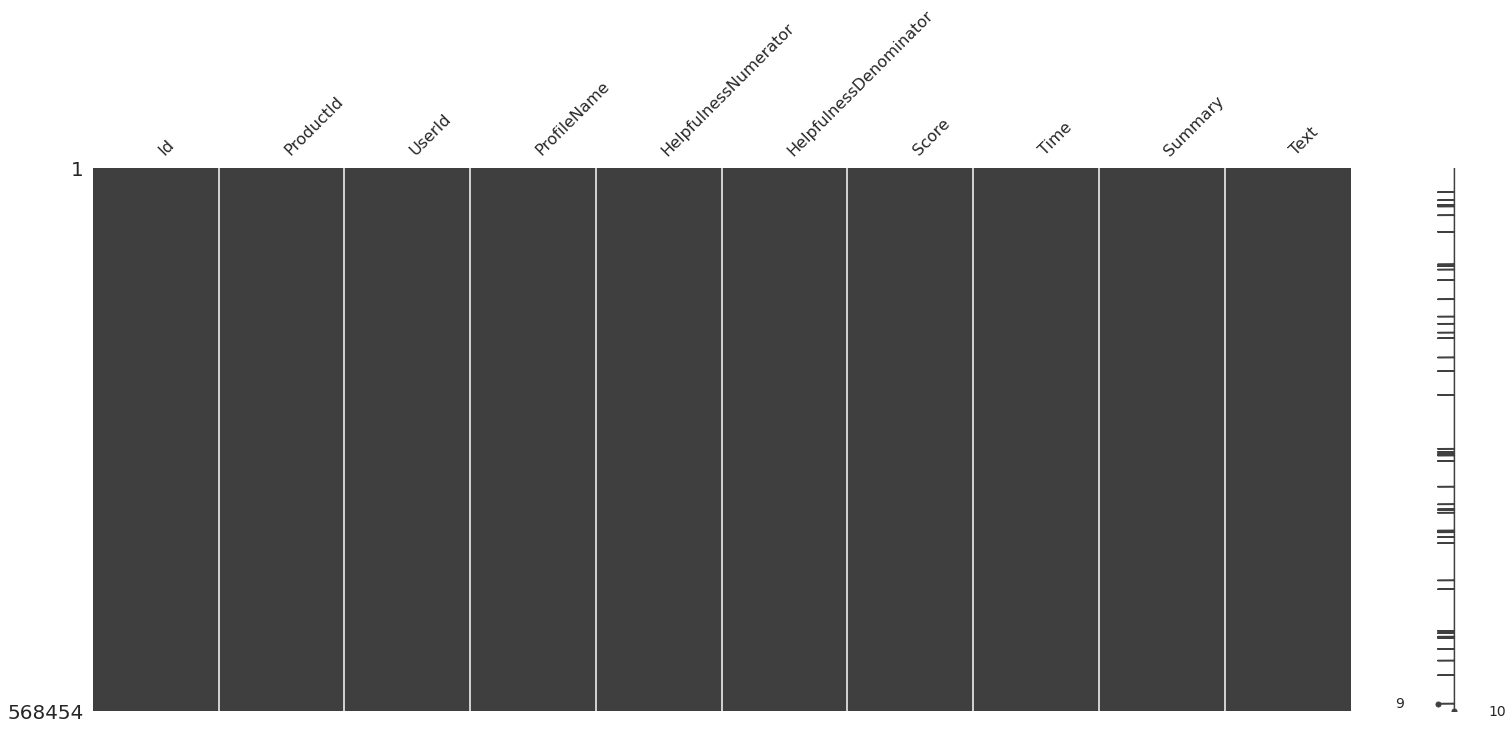

In [ ]:
import missingno as mn
mn.matrix(Reviewsdf)
##ref: https://www.kaggle.com/code/sonalisingh1411/nlp-part-1-amazon-fine-food-sentiment-analysis

In [ ]:
def missing_data(Reviewsdf):
    total = Reviewsdf.isnull().sum().sort_values(ascending = False)
    Percentage = (Reviewsdf.isnull().sum()/Reviewsdf.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, Percentage], axis=1, keys=['Total', 'Percentage'])
missing_data(Reviewsdf)[missing_data(Reviewsdf)["Percentage"]!=0].style.background_gradient(cmap='nipy_spectral')
## ref: https://www.kaggle.com/code/sonalisingh1411/nlp-part-1-amazon-fine-food-sentiment-analysis

,Total,Percentage
Summary,27,0.004750
ProfileName,16,0.002815


### Observations:
* In 'ProfileName' there are 16 Null entries.  
* In 'Summary' there are 27 Null entries.  

### Peak the datapoints having 'ProfileName' Feature as Null

In [ ]:
display(Reviewsdf[Reviewsdf["ProfileName"].isnull()].head())

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
25509,25510,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all g...
38874,38875,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,1278374400,doesn't anyone care that they are putting BHT ...,I called Kellogg's to see why Special K red be...
49800,49801,B000CRHQN0,A2LYFY32LXQDON,NaN,0,0,2,1282608000,They were melted and the chocolate had turned ...,We love these bars but i won't order them ship...
67077,67078,B0006348H2,A2P0P67Y55SNOX,NaN,1,1,5,1314662400,Wheatgrass,Kitty seems to like this sprinkled on her food...
106550,106551,B001EQ5DG0,A1P500QXEG3IUZ,NaN,0,0,5,1326758400,Finally!,"You cannot find this in the stores anymore, it..."


### Observation:
* ProfileName entry is missing, but the corresponding 'UserId' is present which is enough to identify a user who has written the review.

In [ ]:
display(Reviewsdf[Reviewsdf["Summary"].isnull()].head()) 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
33958,33959,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
40548,40549,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
101106,101107,B0014B0HWK,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
102979,102980,B000FVDWU4,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...
117515,117516,B0016B7Z32,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...


### Observation
* The sample reviews above don't have a summary/title of the review. But since the 'text' corresponding to it is present, which may provide much more info about the review context/message, there isn't a problem.
* On a closer look, their text(review) attribute are all duplicated.  
* Everything except the 'ProductId' are same; Even TIME!
* So, it can be safely presume that when a product has different variants(stock-keeping unit (SKU)), review written for any one of the variant gets replicated for all the other variants. And Each Product-Variant Combo gets assigned a different ProductId.
* I may delete the duplicated data in further steps.

#### Check for duplicates

In [ ]:
Non_dup_reviews = Reviewsdf.duplicated(subset=["UserId","ProfileName","Time","Text"], keep='first')
count_dups= Non_dup_reviews.value_counts()

sum_dups = count_dups.sum()
dups_percent = (count_dups/sum_dups) * 100

x = PrettyTable()
x.field_names = ["","Count","Percentage of Total"]
x.add_rows([
    ["Duplicate Reviews", count_dups[True], dups_percent[True]],
    ["Original/Remaining Reviews", count_dups[False], dups_percent[False]],
])
print(x)

+----------------------------+--------+---------------------+
|                            | Count  | Percentage of Total |
+----------------------------+--------+---------------------+
|     Duplicate Reviews      | 174521 |  30.70098899823029  |
| Original/Remaining Reviews | 393933 |  69.29901100176971  |
+----------------------------+--------+---------------------+


### Observation:
* There are about 30% of total reviews which are duplicated across product variants. This means reviews by the same user at the same time with same review text.


In [ ]:
Reviewsdf = Reviewsdf[~Non_dup_reviews]

print(f"Updated No. of entries : {Reviewsdf.shape}")

Updated No. of entries : (393933, 10)


* **I kept only the first entry and deleted rest of the entry**

In [ ]:
Reviewsdf.duplicated().sum()

0

In [ ]:
Reviewsdf.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    3
Text                       0
dtype: int64

## Distribution of Ratings(Scores) across the entire dataset

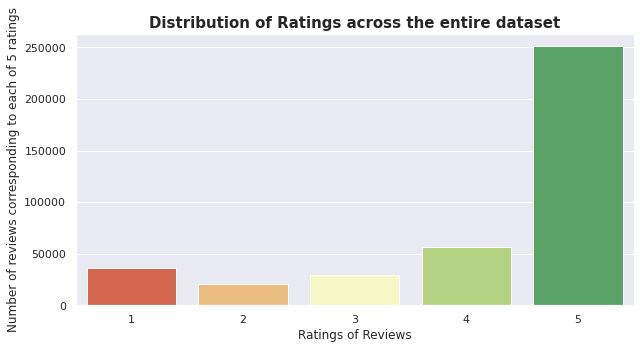

1     36306
2     20802
3     29769
4     56094
5    250962
Name: Score, dtype: int64


In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(Reviewsdf['Score'], palette=sns.color_palette("RdYlGn", 5))
plt.title("Distribution of Ratings across the entire dataset", fontweight='bold', fontsize=15)
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of 5 ratings")
plt.show();

print(Reviewsdf['Score'].value_counts().sort_index());

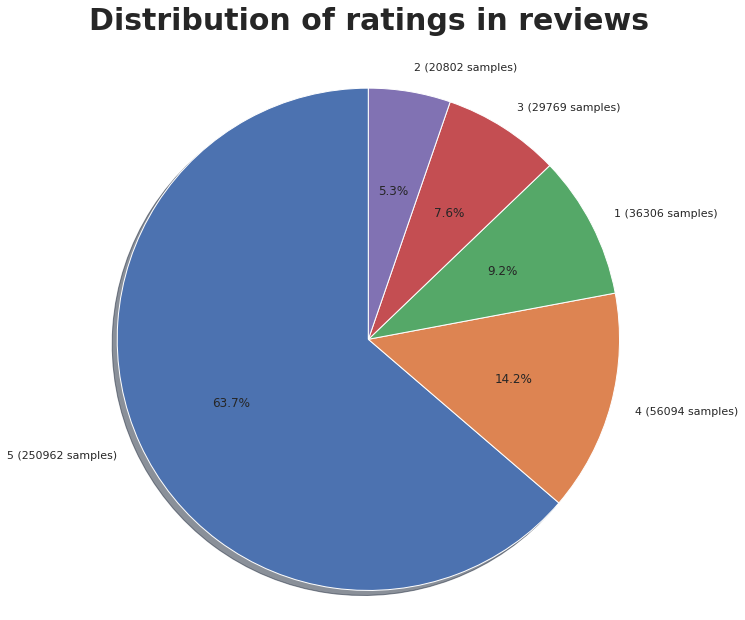

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({Reviewsdf["Score"].value_counts()[k]} samples)' for k in Reviewsdf['Score'].value_counts().keys()]
sizes = dict(Reviewsdf['Score'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Distribution of ratings in reviews",pad=40, fontweight='bold', fontsize=30)
plt.show();

### Observation:  
1. **77.9 percent** of the reviews in the dataset are **positive reviews** having ratings >3 (4 and 5)  
2. **14.5 percent** of the reviews in the dataset are **negative reviews** having ratings <3 (1 and 2)  
3. Remaining **~7.6 percent** reviews have a rating of 3.
4. On the surface, a majority of the reviews are positive, so it can be noted that most of the customers are satisfied with their purchases.

# Analyisis of Reviews over the years

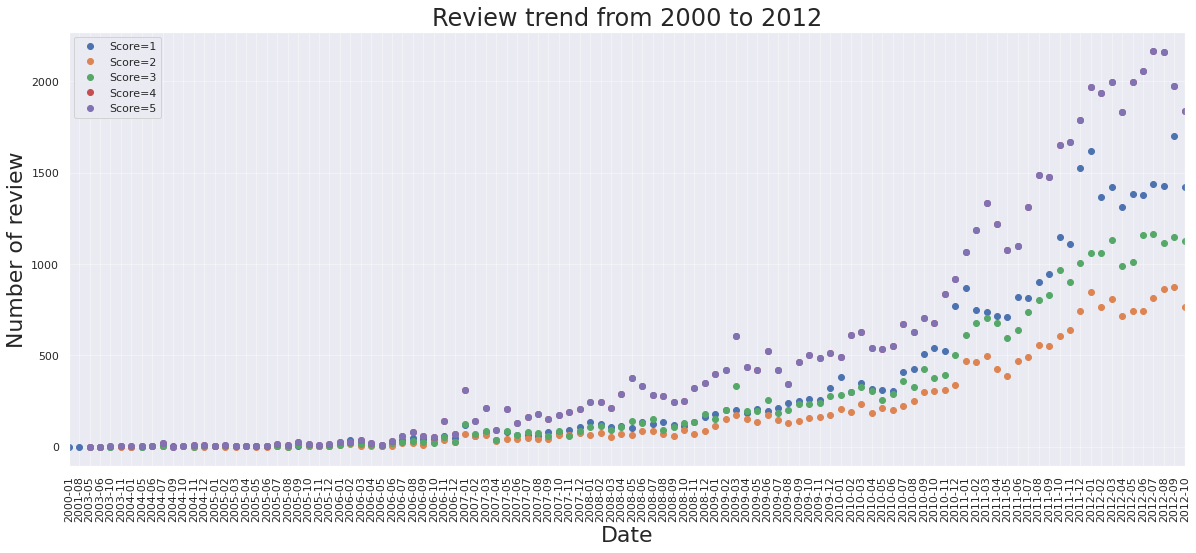

In [ ]:
Reviewsdf['date'] = pd.to_datetime(Reviewsdf['Time'],unit='s')
rev_df = Reviewsdf[['date','Text','Score']]
rev_df.date = Reviewsdf.date.dt.strftime('%Y-%m')
# dff['date'] = dff['date'].dt.to_timestamp()
rev_df = rev_df.sort_values(by=['date']).reset_index(drop=True)
rev_df_1 = rev_df[rev_df['Score'] == 1]
rev_df_2 = rev_df[rev_df['Score'] == 2]
rev_df_3 = rev_df[rev_df['Score'] == 3]
rev_df_4 = rev_df[rev_df['Score'] == 4]
rev_df_5 = rev_df[rev_df['Score'] == 5]

rev_df_1 = rev_df_1.groupby('date')['Score'].count().reset_index()
rev_df_2 = rev_df_2.groupby('date')['Score'].count().reset_index()
rev_df_3 = rev_df_3.groupby('date')['Score'].count().reset_index()
rev_df_5 = rev_df_4.groupby('date')['Score'].count().reset_index()
rev_df_4 = rev_df_4.groupby('date')['Score'].count().reset_index()

plt.figure(figsize=(20,8))

plt.plot_date(x=rev_df_1['date'],y=rev_df_1['Score'],label='Score=1')
plt.plot_date(x=rev_df_2['date'],y=rev_df_2['Score'],label='Score=2')
plt.plot_date(x=rev_df_3['date'],y=rev_df_3['Score'],label='Score=3')
plt.plot_date(x=rev_df_4['date'],y=rev_df_4['Score'],label='Score=4')
plt.plot_date(x=rev_df_5['date'],y=rev_df_5['Score'],label='Score=5')
plt.grid(linewidth=0.5,alpha=0.75)
plt.xticks(rotation=90)
plt.xlim('2000-01','2012-10')
plt.xlabel('Date',fontsize=22)
plt.ylabel('Number of review',fontsize=22)
plt.title('Review trend from 2000 to 2012',fontsize=24);
plt.savefig('review_trend.png')
plt.legend()
plt.show()

### Observation:
1. The reviews have increased over the years.
2. The reviews scored that have increased the most/mostly given by the customers are positive 5 and negative 1.

# Analysis on Score (Target Variable)

Now I will create the target variable - "Score" from the review stars. First I will filter only those reviews with rating > 3(positive) and less than 3(negative) and discard those reviews with rating 3 since it is a neutral score and review.

In [ ]:
Reviews = Reviewsdf[Reviewsdf['Score'] != 3]
print(f'Reviews shape is: {(Reviews.shape)}')

#Checking to see how much % of data still remains
print(f'Remaining data is {((Reviews.shape[0]*1.0)/(Reviewsdf.shape[0]*1.0))*100}')

Reviews shape is: (364164, 11)
Remaining data is 92.44313119236011


In [ ]:
score = Reviews['Score'].apply(lambda x: 1 if x > 3 else 0)
Reviews['Score'] = score
Reviews.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18


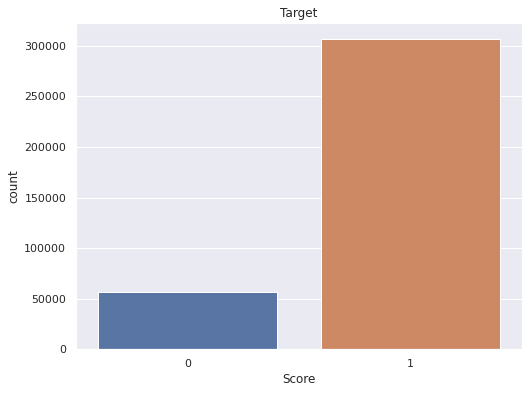

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(Reviews['Score'])
plt.title('Target')
plt.show()

**Observation:**

There is an imbalenced dataset for classification, so the accuracy cannot be chosen as a metric. Will go with AUC(Area under ROC curve)

> Why accuracy not for imbalanced datasets?

Consider a scenario like this where we have imbalenced dataset. For example consider case of credit card fraud detection with 98% percentage of points as non-fraud(1) and rest 2% points as fraud(1). In such cases even if we predict all the points as non-fraud also we will get 98% accuracy. But actually it is not the case. So we can't use accuracy as a metric. - **Look into this Mercy**

> What is AUC ROC?

AUC is the area under ROC curve. It tells how much the model is capable of distinguishing between classes. The higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

# Analysis On ProductId and UserId

In [ ]:
# we will see the products brought by each customer

purchases = Reviews[['ProductId','UserId']].groupby('UserId').agg({'ProductId': ['count']})
purchases.columns = ['No_of_products_purchased']
purchases = purchases.reset_index()
purchases.head(2)

,UserId,No_of_products_purchased
0,#oc-R103C0QSV1DF5E,1
1,#oc-R109MU5OBBZ59U,1


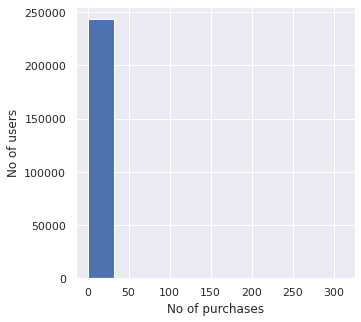

count    243412.000000
mean          1.496081
std           2.537677
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         310.000000
Name: No_of_products_purchased, dtype: float64


In [ ]:
plt.figure(figsize=(5,5))
purchases['No_of_products_purchased'].hist()
plt.xlabel('No of purchases')
plt.ylabel('No of users')
plt.show()
print(purchases['No_of_products_purchased'].describe())

Can be noted that majority of the users purchased only 1 product. Maximum number of product purchased by a single user is 310

# Analysis on HelpfulnessNumerator and HelpfulnessDenominator

* Helpfulness Numerator: Number of users who found the review helpful
* Helpfulness Denominator: Number of users who indicated whether they found the review helpful or not

In [ ]:
Reviews[Reviews['HelpfulnessNumerator'] > Reviews['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,1,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,2008-06-08
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,1,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,2008-10-25


It can also be seen that in two rows given above the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
Reviews = Reviews[Reviews['HelpfulnessNumerator'] <= Reviews['HelpfulnessDenominator']]
Reviews.shape

(364162, 11)

In [ ]:
#Checking to see how much % of data still remains
print(f'Remaining data is {((Reviews.shape[0]*1.0)/(Reviewsdf.shape[0]*1.0))*100}')

Remaining data is 92.44262349181206


# Feature Engineering 1

In [ ]:
Reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,date
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21


In [ ]:
%%time
Reviews["HelpfulnessPercentage"] = Reviews[["HelpfulnessNumerator","HelpfulnessDenominator"]].apply(lambda x: ((x[0]/x[1])*100.0) if x[1] else 0.0, axis=1)
Reviews = Reviews.drop(["HelpfulnessNumerator","HelpfulnessDenominator"], axis=1)
Reviews.head()

CPU times: user 3.33 s, sys: 26.4 ms, total: 3.35 s
Wall time: 3.34 s


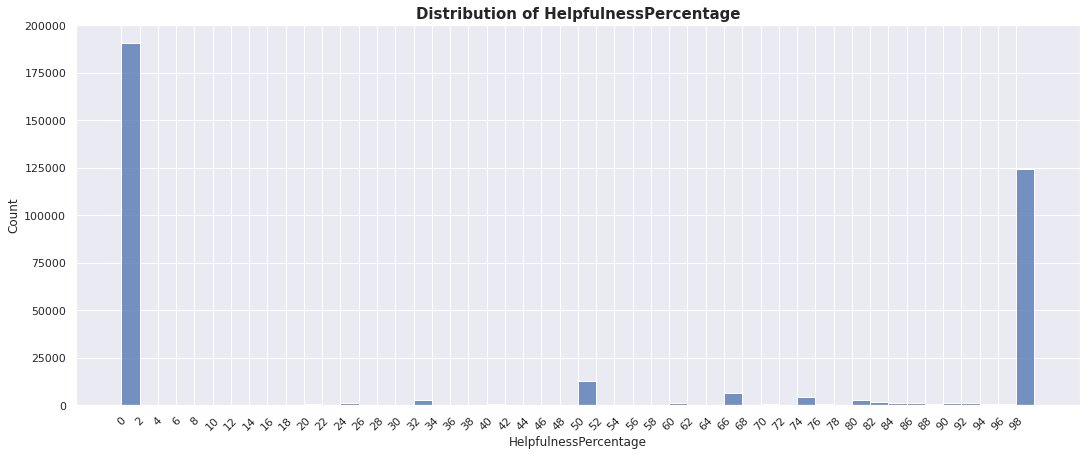

In [ ]:

plt.figure(figsize=(18, 7))
sns.histplot(data=Reviews["HelpfulnessPercentage"], bins=50)
plt.title("Distribution of HelpfulnessPercentage",fontweight='bold', fontsize=15)
plt.xticks(range(0,100,2), rotation=45)
plt.show();

In [ ]:
# Assigning Helpfulness indicator
Reviews.loc[Reviews["HelpfulnessPercentage"] >= 75, 'Helpfulness_indicator'] = 'Useful'
Reviews.loc[(Reviews["HelpfulnessPercentage"] > 40) & (Reviews["HelpfulnessPercentage"] < 75), 'Helpfulness_indicator'] = 'Intermediate'
Reviews.loc[(Reviews["HelpfulnessPercentage"] > 0) & (Reviews["HelpfulnessPercentage"] <= 40), 'Helpfulness_indicator'] = 'Not Useful'
Reviews.loc[Reviews["HelpfulnessPercentage"] == 0, 'Helpfulness_indicator'] = 'Not Available'

Reviews = Reviews.drop(["HelpfulnessPercentage"], axis=1)

Reviews.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,date,Helpfulness_indicator
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,Useful
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,Not Available
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,Useful
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,Useful
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,Not Available


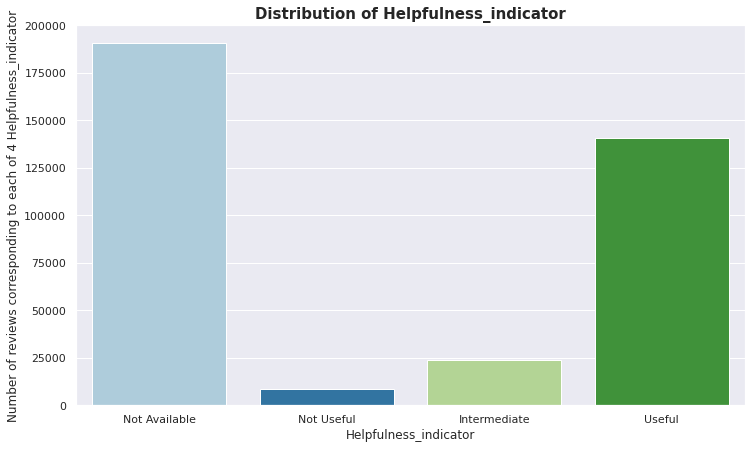

Not Available    190807
Not Useful         8577
Intermediate      23955
Useful           140823
Name: Helpfulness_indicator, dtype: int64


In [ ]:
plt.figure(figsize=(12,7))
sns.countplot(Reviews['Helpfulness_indicator'], palette=sns.color_palette("Paired", 4), order=["Not Available","Not Useful","Intermediate","Useful"])
plt.title("Distribution of Helpfulness_indicator",fontweight='bold', fontsize=15)
plt.xlabel("Helpfulness_indicator")
plt.ylabel("Number of reviews corresponding to each of 4 Helpfulness_indicator")
plt.show();

print(Reviews['Helpfulness_indicator'].value_counts()[[0,3,2,1]]);

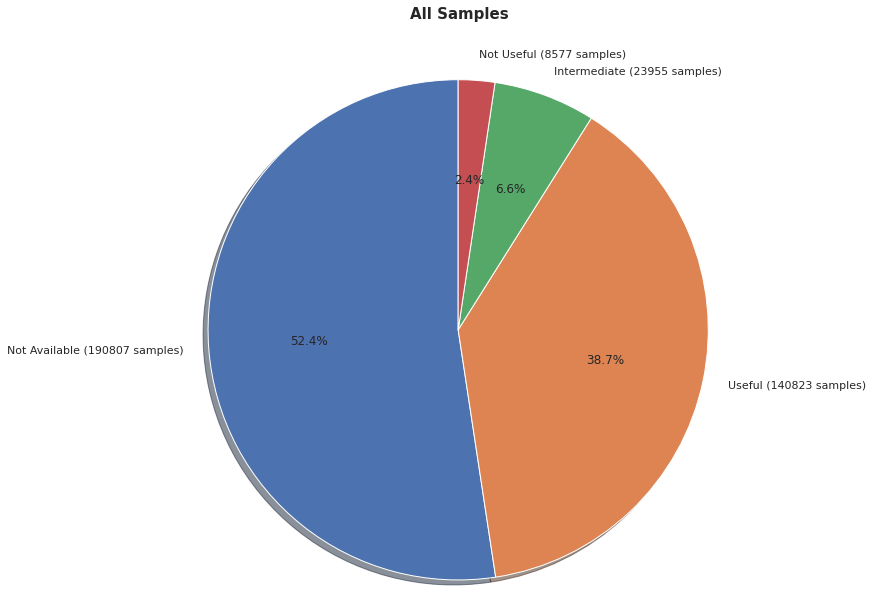

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({Reviews["Helpfulness_indicator"].value_counts()[k]} samples)' for k in Reviews['Helpfulness_indicator'].value_counts().keys()]
sizes = dict(Reviews['Helpfulness_indicator'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("All Samples", pad=40,fontweight='bold', fontsize=15)
plt.show();

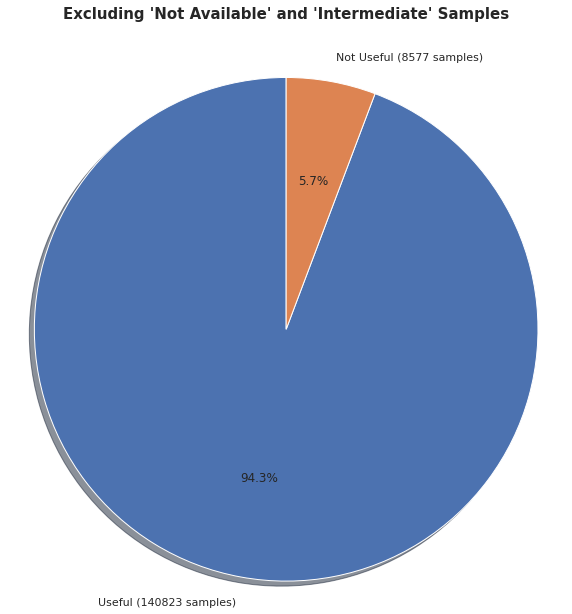

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({Reviews["Helpfulness_indicator"].value_counts()[k]} samples)' for k in ['Useful','Not Useful']]
sizes = dict(Reviews['Helpfulness_indicator'].value_counts())
sizes.pop('Not Available')
sizes.pop('Intermediate')
sizes = sizes.values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Excluding 'Not Available' and 'Intermediate' Samples", pad=40, fontweight='bold', fontsize=15)
plt.show();

### Assigning 'Sentiment_Class' Feature:

Score > 3 (4,5) -> Positive    
Score < 3 (1,2) -> Negative

In [ ]:
Reviews.loc[Reviews.Score == 1, ['Sentiment_Class']] = 'Positive'

In [ ]:
Reviews.loc[Reviews.Score == 0, 'Sentiment_Class'] = 'Negative'

In [ ]:
SentimentClass = Reviews['Sentiment_Class']

In [ ]:
Reviews[SentimentClass == 'Positive']

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,date,Helpfulness_indicator,Sentiment_Class
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,Useful,Positive
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,Useful,Positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,Not Available,Positive
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,1,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,2012-07-12,Not Available,Positive
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,1,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,2012-06-20,Not Available,Positive
...,...,...,...,...,...,...,...,...,...,...,...
568448,568449,B001EO7N10,A1F6BHEYB7R6R7,James Braley,1,1308096000,Very large ground spice jars.,My only complaint is that there's so much of i...,2011-06-15,Not Available,Positive
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,2011-03-09,Not Available,Positive
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21,Useful,Positive
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13,Useful,Positive


In [ ]:
Reviews.head(2)

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,date,Helpfulness_indicator,Sentiment_Class
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,Useful,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,Not Available,Negative


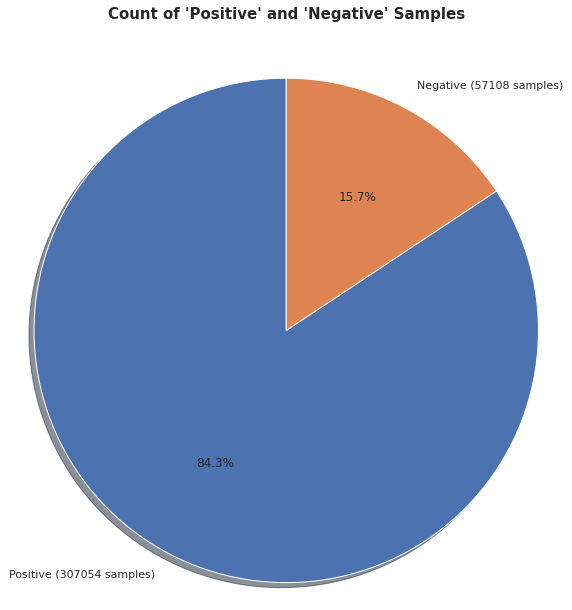

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({Reviews["Sentiment_Class"].value_counts()[k]} samples)' for k in Reviews['Sentiment_Class'].value_counts().keys()]
sizes = dict(Reviews['Sentiment_Class'].value_counts())
sizes = sizes.values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Count of 'Positive' and 'Negative' Samples", pad=40, fontweight='bold', fontsize=15)
plt.show();

# EDA 2 (After Data Cleaning, FE1)

## Distribution of useful and non-useful reviews in each of the set of Positive and Negative Reviews.

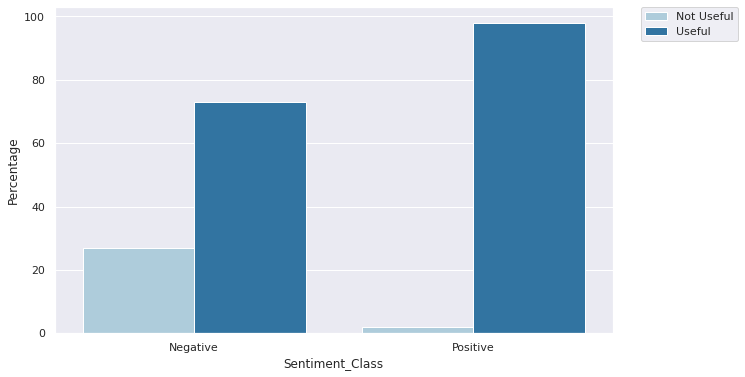

,Sentiment_Class,Helpfulness_indicator,Percentage
0,Negative,Useful,73.078284
1,Negative,Not Useful,26.921716
2,Positive,Useful,98.036123
3,Positive,Not Useful,1.963877


In [ ]:
Reviewsdf_temp = Reviews[(Reviews["Helpfulness_indicator"]!= "Not Available") & (Reviews["Helpfulness_indicator"]!= "Intermediate")]
Reviewsdf_temp_1 = Reviewsdf_temp["Helpfulness_indicator"].groupby(Reviewsdf_temp["Sentiment_Class"]).value_counts(normalize=True)
Reviewsdf_temp_1 = Reviewsdf_temp_1*100
Reviewsdf_temp_1 = Reviewsdf_temp_1.rename("Percentage").reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=Reviewsdf_temp_1, x="Sentiment_Class", y="Percentage", hue="Helpfulness_indicator", hue_order=["Not Useful","Useful"], palette=sns.color_palette("Paired", 2));
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()
Reviewsdf_temp_1

## Distribution of Positive and Negative Reviews in each of the set of useful and non-useful reviews

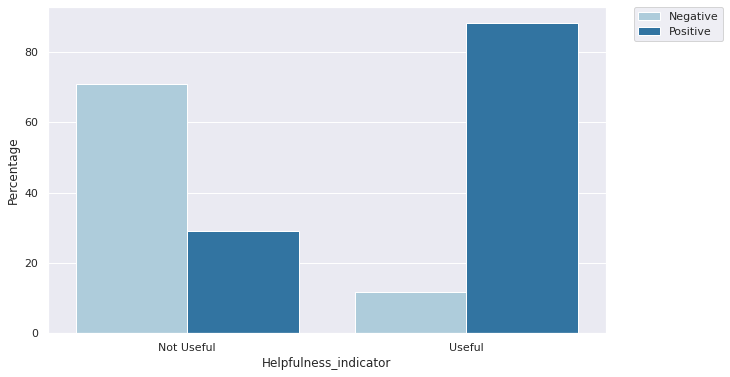

,Helpfulness_indicator,Sentiment_Class,Percentage
0,Not Useful,Negative,70.968870
1,Not Useful,Positive,29.031130
2,Useful,Positive,88.266831
3,Useful,Negative,11.733169


In [ ]:
Reviewsdf_temp = Reviews[(Reviews["Helpfulness_indicator"]!= "Not Available") & (Reviews["Helpfulness_indicator"]!= "Intermediate")]
Reviewsdf_temp_1 = Reviewsdf_temp["Sentiment_Class"].groupby(Reviewsdf_temp["Helpfulness_indicator"]).value_counts(normalize=True)
Reviewsdf_temp_1 = Reviewsdf_temp_1*100 
Reviewsdf_temp_1 = Reviewsdf_temp_1.rename("Percentage").reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=Reviewsdf_temp_1, x="Helpfulness_indicator", y="Percentage", hue="Sentiment_Class", hue_order=["Negative","Positive"], palette=sns.color_palette("Paired", 2));
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()
Reviewsdf_temp_1

## EDA Observations (Consolidated):
* Positive reviews are more common than negative reviews.
* Positive reviews are shorter (in terms of word count)
* Helpful reviews are longer.
* Despite being shorter, Positive reviews are found to be more helpful.


# Data Preprocessing

# Preprocessing Text data

Now need to complete some preprocessing of the data before going onto the analysis part and making the prediction model.

**Preprocessing phase:-**

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords

### Remove html tags

In [ ]:
# Reviews['text'] = Reviews['Summary'] + Reviews['Text']
Reviews['text'] = Reviews['Text']

In [ ]:
import re

# Ref: https://stackoverflow.com/a/12982689
def remove_html_tags(sentence):
    pattern = re.compile("<.*?>") # Match any text wrapped with < and > along with the < and >
    cleaned_sentence = re.sub(pattern,'',sentence).strip()
    return cleaned_sentence

sentence = "<a href='sample.com'> <b> Click </b> here <br/> </a>"
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_html_tags(sentence)}")

Sample
Before: <a href='sample.com'> <b> Click </b> here <br/> </a>
After: Click  here


### Remove URLs (starting with 'http' as well as 'www')

In [ ]:
# Ref: https://stackoverflow.com/a/12982689
def remove_urls(sentence):
    http_pattern = re.compile(r"http\S+") # Matches all words starting with 'http' and followed by 1 or more occurance of non-whitespace characters
    cleaned_sentence = re.sub(http_pattern,'',sentence).strip()
    www_pattern = re.compile(r"www\S+") # Matches all words starting with 'www' and followed by 1 or more occurance of non-whitespace characters
    cleaned_sentence = re.sub(www_pattern,'',cleaned_sentence)
    return cleaned_sentence

sentence = """url starting with http s : https://www.google.com/search?q=Amazon&oq=Amazon&aqs=chrome..69i57j69i59j35i39j46i67i131i199i433i465j0i67l3j0i67i433j0i67j0i131i433i512.1005j0j15&sourceid=chrome&ie=UTF-8
url starting with http : http://google.com
url starting with www : www.google.co.in"""
print("Sample\n")
print(f"Before:\n {sentence}\n")
print(f"After:\n {remove_urls(sentence)}")

Sample

Before:
 url starting with http s : https://www.google.com/search?q=Amazon&oq=Amazon&aqs=chrome..69i57j69i59j35i39j46i67i131i199i433i465j0i67l3j0i67i433j0i67j0i131i433i512.1005j0j15&sourceid=chrome&ie=UTF-8
url starting with http : http://google.com
url starting with www : www.google.co.in

After:
 url starting with http s : 
url starting with http : 
url starting with www : 


### Removing HTML Entities like &nbsp, &#60, a&#771('a' with a bar on top), etc.

In [ ]:
# Ref: https://www.w3schools.com/html/html_entities.asp
# Ref: https://stackoverflow.com/a/12982689
def remove_html_entities(sentence):
    pattern = re.compile("&[a-z0-9]+|&#[0-9]{1,6}|&#x[0-9a-f]{1,6}")
    cleaned_sentence = re.sub(pattern,'',sentence).strip()
    return cleaned_sentence

sentence = "&nbsp, &#60, a&#771"
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_html_entities(sentence)}")

Sample
Before: &nbsp, &#60, a&#771
After: , , a


### Remove words with numbers 

In [ ]:
# Ref: https://stackoverflow.com/a/18082370/4084039
def remove_words_with_numbers(sentence):
    pattern = re.compile("\S*\d\S*") # Match a word starting with 0 or more occurances of a non whitespace character, then a digit followed by 0 or more occurances of a non whitespace character
    cleaned_text = re.sub(pattern,"", sentence).strip()
    return cleaned_text

sentence = "  The5 number is removed removed55 "
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_words_with_numbers(sentence)}")

Sample
Before:   The5 number is removed removed55 
After: number is removed


### Remove words with 3 or more repeated characters (words like 'happpyyy')

In [ ]:
# Ref : https://stackoverflow.com/a/37013006
def remove_words_with_repeated_characters(sentence): 
    pattern = re.compile("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b")
    cleaned_text  = re.sub(pattern,' ',sentence)
    return (cleaned_text)

sentence = "This looks soooooooo good! I am so happpyyy aa aaa aaaa"
print("Sample")
print(f"Before: {sentence}")
print(f"After: {remove_words_with_repeated_characters(sentence)}")

Sample
Before: This looks soooooooo good! I am so happpyyy aa aaa aaaa
After: This looks  good! I am so  aa  


In [ ]:
# replacing some phrases like "won't, will not"

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])



preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(Reviews['text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    # removing further html tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = remove_html_tags(sentence)
    # removing urls:
    sentence = remove_urls(sentence)
    # removing HTML Entities like &nbsp, &#60, a&#771('a' with a bar on top), etc.:
    sentence = remove_html_entities(sentence)
    # removing words with numbers:
    sentence = remove_words_with_numbers(sentence)
    # remove words with 3 or more repeated characters (words like 'happpyyy'):
    sentence =  remove_words_with_repeated_characters(sentence)
    # removing non alphabels
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 364162/364162 [02:28<00:00, 2455.37it/s]


In [ ]:
#combining required columns
Reviews['clean_text'] = preprocessed_reviews
Reviews = Reviews[['Time','clean_text', 'Score']]

#reseting index
Reviews = Reviews.reset_index(drop=True)

#saving processed file
Reviews.to_csv('ProcessedRevs.csv',index=False)

In [ ]:
Reviews

,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0
2,1219017600,confection around centuries light pillowy citr...,1
3,1307923200,looking secret ingredient robitussin believe f...,0
4,1350777600,great taffy great price wide assortment yummy ...,1
...,...,...,...
364157,1299628800,great sesame chicken good not better resturant...,1
364158,1331251200,disappointed flavor chocolate notes especially...,0
364159,1329782400,stars small give one training session tried tr...,1
364160,1331596800,best treats training rewarding dog good groomi...,1


## Wordcloud for Reviews.
### Plotting word cloud to understand the top words that have occurred most frequently in the reviews.

There are 93076587 words in the combination of all review.


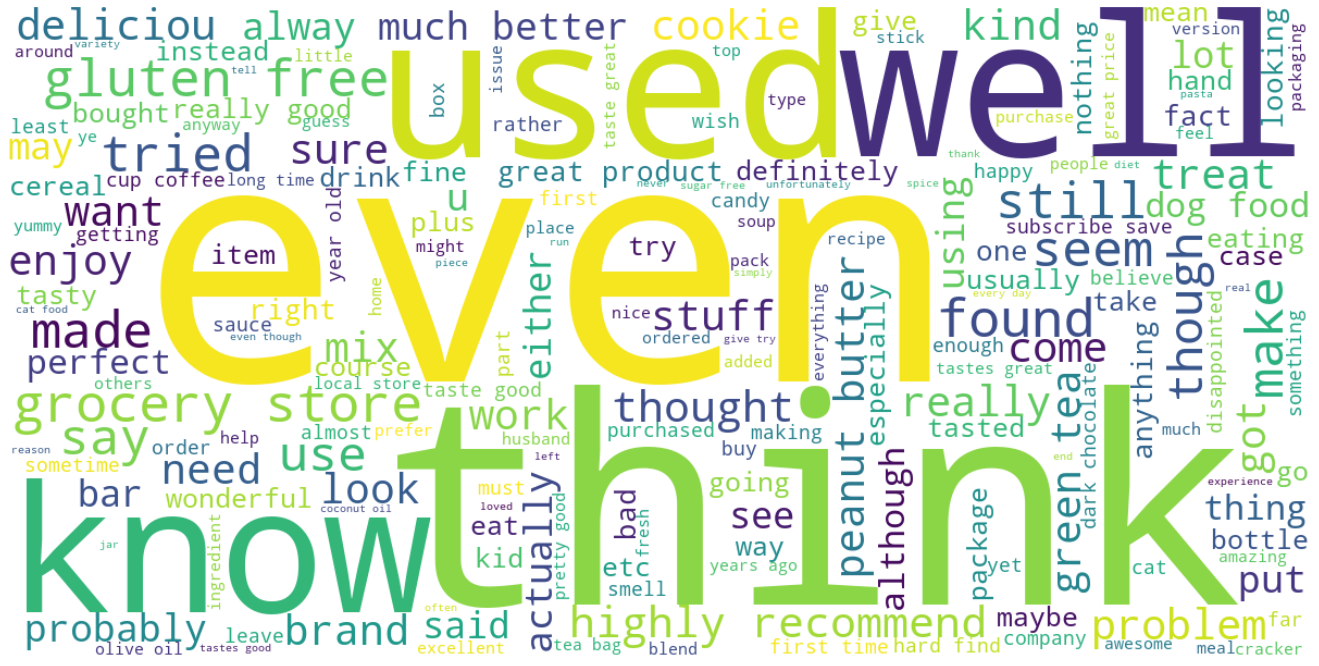

CPU times: user 1min 8s, sys: 2.73 s, total: 1min 11s
Wall time: 1min 11s


In [ ]:
%%time

from nltk.corpus import stopwords
from wordcloud import WordCloud

text = " ".join(review for review in Reviews["clean_text"])
print ("There are {} words in the combination of all review.".format(len(text)))

# # Create stopword list:
# remove_html_tags(text)
# Generate a word cloud image
wordcloud = WordCloud(background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observations:
* The words "even", "think", "well", "however", "know" in the reviews have a high frequency(big size among the word counts) of occurrence. This means that the words occur more times than other words in the reviews.

### Plotting word cloud to understand the top words that have occured most frequently in the POSITIVE reviews.

There are 77034691 words in the combination of all positive reviews.


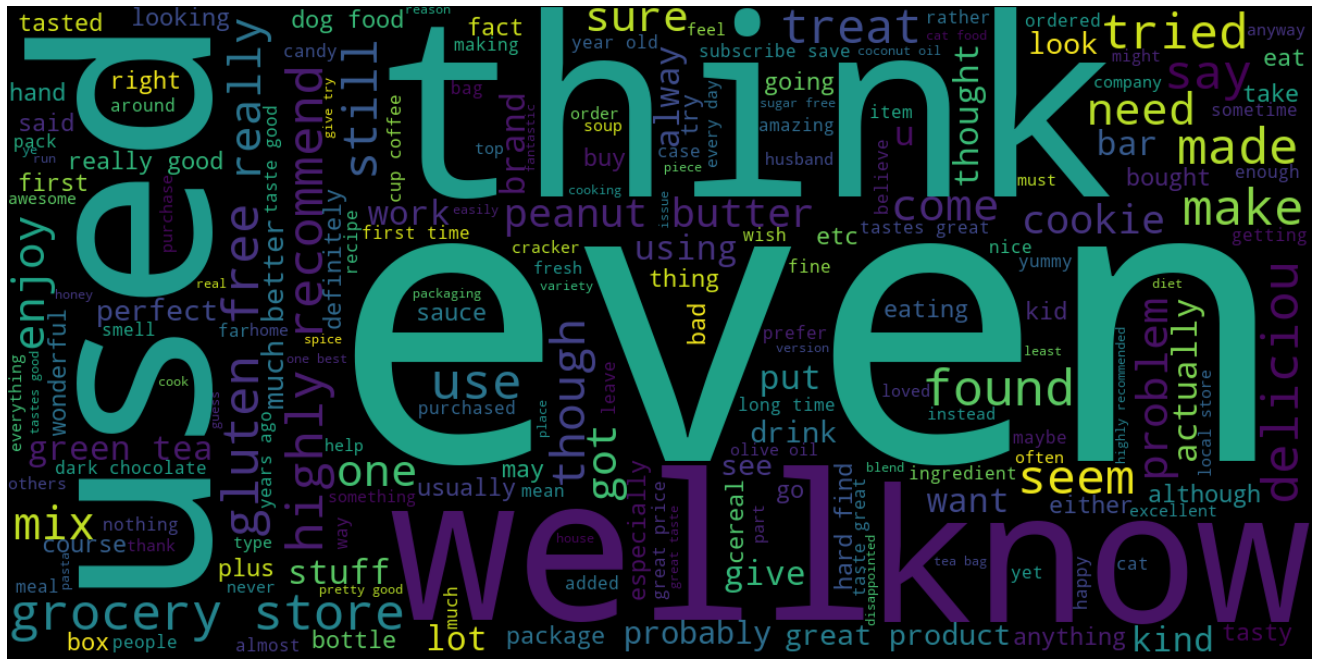

CPU times: user 58.4 s, sys: 1.88 s, total: 1min
Wall time: 1min


In [ ]:
%%time
Reviewsdf_positive = Reviews[Reviews["Score"] == 1]
text = " ".join(review for review in Reviewsdf_positive["clean_text"])
print ("There are {} words in the combination of all positive reviews.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(background_color="black", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Observations:
* I can see the words: "highly recommend", "much better", "great product", "loved", "enjoy", and "perfect". However, there are negative words such as "problem", still noted in the wordcloud above.

In [ ]:
# from nltk.corpus import stopwords

# def generate_ngrams(text, n_gram=1):
#     token = [token for token in text.lower().split(' ') if token != '' if token not in stopwords.words('english')]
#     ngrams = zip(*[token[i:] for i in range(n_gram)])
#     return [' '.join(ngram) for ngram in ngrams]

In [ ]:
# N = 10

In [ ]:
# Reviews['clean_text'] = [' '.join(Reviews['clean_text'][i].split()) for i in range(len(Reviews))]

In [ ]:
# Reviews['clean_text']=Reviews['clean_text'].str.replace("br","")

In [ ]:
# import collections


# less_toxic_unigrams = collections.defaultdict(int)
# for review in Reviews['clean_text']:
#     for word in generate_ngrams(review, 1):
#         less_toxic_unigrams[word] += 1
        
# df_less_toxic_unigrams = pd.DataFrame(sorted(less_toxic_unigrams.items(), key=lambda x: x[1])[::-1])

# unigrams_less_11 = df_less_toxic_unigrams[:N]

# fig = px.bar(x=unigrams_less_11[1], y=unigrams_less_11[0], orientation='h',color =unigrams_less_11[0],color_discrete_sequence = ["#004529","#f6fcb8"])
# fig.update_layout(title = "<b> Top 10 Most Common Uni-grams In Text </b>",xaxis_title="",yaxis_title="<b> Frequency </b>",font_size=18, plot_bgcolor="#fff",showlegend=False) 

### Read in the Processed file

In [ ]:
PrsdReviews = pd.read_csv('ProcessedRevs.csv')
print(PrsdReviews.shape)
PrsdReviews.head()

(364162, 3)


,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0
2,1219017600,confection around centuries light pillowy citr...,1
3,1307923200,looking secret ingredient robitussin believe f...,0
4,1350777600,great taffy great price wide assortment yummy ...,1


In [ ]:
PrsdReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364162 entries, 0 to 364161
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        364162 non-null  int64 
 1   clean_text  363184 non-null  object
 2   Score       364162 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ MB


In [ ]:
PrsdReviews.isnull().sum()

Time            0
clean_text    978
Score           0
dtype: int64

In [ ]:
# Drop empty rows

PrsdReviews = PrsdReviews.dropna(axis=0)
PrsdReviews.shape

(363184, 3)

In [ ]:
PrsdReviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363184 entries, 0 to 364161
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Time        363184 non-null  int64 
 1   clean_text  363184 non-null  object
 2   Score       363184 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 11.1+ MB


**Looking at 'time' beacuse the reviews are developed over time. So splitting based on that makes more sense.**

In [ ]:
#sampling 100k points

PrsdReviews = PrsdReviews.sample(100000,random_state=100)

In [ ]:
#sortimg based on time

PrsdReviews['Time'] = pd.to_datetime(PrsdReviews['Time'],unit='s')
PrsdReviews = PrsdReviews.sort_values('Time')
PrsdReviews = PrsdReviews.reset_index(drop=True)

In [ ]:
# ukvbrhebvlusblhrl 

Split data to train, cv and test

In [ ]:
#splitting data to train and test

from sklearn.model_selection import train_test_split

x = PrsdReviews['clean_text']
y = PrsdReviews['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)

# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)

print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (70000,)
shape of X_test is (30000,)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [ ]:
np.save('X_train', X_train)
np.save('y_train', y_train)
np.save('X_test', X_test)
np.save('y_test', y_test)

# Bag of Words

In [ ]:
bow = CountVectorizer()
bow.fit(X_train)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (70000, 50574)
shape of X_test_bow is (30000, 50574)


In [ ]:
#saving bow vectors
import pickle

pickle.dump(X_train_bow, open("X_train_bow","wb"))
pickle.dump(X_test_bow, open("X_test_bow","wb"))
pickle.dump(np.array(bow_features), open("bow_features","wb"))

# Tfidf

In [ ]:
#applying bow on x_train and x_test

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)
tfidf_features = vectorizer.get_feature_names()

# use the fitted CountVectorizer to convert the text to vector

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
#saving tfidf vectors

pickle.dump(X_train_tfidf, open("X_train_tfidf","wb"))
pickle.dump(X_test_tfidf, open("X_test_tfidf","wb"))
pickle.dump(np.array(tfidf_features), open("tfidf_features","wb"))

# Word2vec

In [ ]:
preprocessed_reviews = X_train.values
train_sentence = [rev.split() for rev in preprocessed_reviews]

# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector

w2v_model_train = Word2Vec(train_sentence,min_count=5,size=50, workers=4) # use vector_size, if size causes an error
w2v_words = list(w2v_model_train.wv.wv.vocab) # use .index_to_key if .vocab causes an error

In [ ]:
pickle.dump(np.array(w2v_words),open("w2v_words","wb"))

# Average Word2vec

In [ ]:
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]

sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

########################################################
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]

sent_vectors_test = []
for sent in tqdm(test_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 70000/70000 [02:09<00:00, 540.26it/s]


70000
50


100%|██████████| 30000/30000 [00:56<00:00, 527.79it/s]

30000
50


In [ ]:
X_train_avgw2v = np.array(sent_vectors_train)
X_test_avgw2v = np.array(sent_vectors_test)

pickle.dump(np.array(X_train_avgw2v), open("X_train_avgw2v","wb"))
pickle.dump(np.array(X_test_avgw2v), open("X_test_avgw2v","wb"))

# Tfidf Word2Vec

In [ ]:
w2v_words = pickle.load(open("w2v_words","rb")).tolist()
tfidf = TfidfVectorizer()
tfidf.fit(X_train)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

#saving
pickle.dump(tfidf_feats, open("tfidf_feats_w2v","wb"))

In [ ]:
train_reviews = X_train.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])
X_train_tfw2v = sent_vectors_train

pickle.dump(np.array(X_train_tfw2v), open("X_train_tfw2v","wb"))

100%|██████████| 70000/70000 [28:10<00:00, 41.40it/s]

70000
[-0.69531493  0.46957839  1.13674547  0.0984562  -0.44029488  0.43687173
  0.0134092   0.70298703  0.16379877 -0.12216301  0.39638364  0.74772736
 -0.77001333  0.78841162 -0.13706582 -0.33967342  0.41824683  0.05074403
  0.05806111  0.16596748  0.12142948 -0.14807062  0.20094474 -0.09610971
  0.09185451 -0.60487223 -1.17040506  0.00671654 -0.56466625  0.41596956
  0.46153191  0.2210392  -0.48221869 -0.72703307 -0.61188321 -0.38290863
  0.48759515  0.95956201 -0.18683495 -0.84022087 -0.62940071 -0.6863367
 -0.98291542  0.42450175  0.07744779 -0.71291214 -0.40440274  1.21529334
  0.42976139 -0.43052003]


In [ ]:
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(sent_vectors_test[0])   

100%|██████████| 30000/30000 [11:59<00:00, 41.69it/s]

30000
[ 0.11710241  0.46272275  0.2737797   0.03653662  0.09303285  0.26550379
  0.02180423  0.11378047  0.29949351 -0.26456749  0.11273553  0.72714573
 -0.96283415  0.73695401  0.03790085 -0.11440026 -0.06855326 -0.24340371
  0.27635901 -0.09723511  0.05875539  0.3570339  -0.4949499   0.37315846
  0.78643031 -0.50391864 -0.01451979 -0.237078   -0.23935076  0.48052628
 -0.00605205 -0.0968954   0.56348487  0.1001643  -0.43199928 -0.11795321
  0.27012833  0.07883991 -0.30919257 -0.8461179   0.44139881  0.49094635
 -0.12401866  0.02438384  0.04969071 -0.40279571 -0.16141533 -0.67139466
  0.47992682 -0.35829049]


In [ ]:
X_test_tfw2v = sent_vectors_test

pickle.dump(np.array(X_test_tfw2v), open("X_test_tfw2v","wb"))

# Loading saved vectors

In [ ]:
# loading bow vectors
X_train_bow = pickle.load(open("X_train_bow","rb"))
X_test_bow = pickle.load(open("X_test_bow","rb"))
bow_features = pickle.load(open("bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("X_test_tfidf","rb"))
tfidf_features = pickle.load(open("tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_train = np.load('y_train.npy',allow_pickle=True)
y_test = np.load('y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 50574)
shape of X_test_bow is (30000, 50574)
shape of X_train_tfidf is (70000, 50574)
shape of X_test_tfidf is (30000, 50574)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of X_train_tfw2v is (70000, 50)
shape of X_test_tfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


### Coninuation: BOW, TFIDF, Word2Vec, Avg Word2vec, TFIDF W2v

## Loading the processed data

In [ ]:
rev_df = pd.read_csv('ProcessedRevs.csv')
rev_df = rev_df.dropna(axis=0)
print(rev_df.shape)
rev_df.head()

(363184, 3)


,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0
2,1219017600,confection around centuries light pillowy citr...,1
3,1307923200,looking secret ingredient robitussin believe f...,0
4,1350777600,great taffy great price wide assortment yummy ...,1


In [ ]:
rev_df1 = rev_df[rev_df['Score'] == 1].sample(2000)
rev_df0 = rev_df[rev_df['Score'] == 0].sample(2000)
rev_dff = pd.concat([rev_df1,rev_df0],axis=0)
PDReviews = rev_dff.sample(frac=1).reset_index(drop=True)
PDReviews.head(3)

,Time,clean_text,Score
0,1319587200,rootbeer extract unlike ever heavy wintergreen...,0
1,1339027200,first state regularly buy via instant coffees ...,0
2,1332806400,favorite brand gum hard find local stores chec...,1


### BOW

In [ ]:
preprocessed_reviews = PDReviews['clean_text'].values

In [ ]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

bow_vector = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(bow_vector))
print("the shape of out text BOW vectorizer ",bow_vector.get_shape())
print("the number of unique words ", bow_vector.get_shape()[1])

some feature names  ['aaah', 'aafco', 'aamazon', 'ab', 'aback', 'abc', 'abd', 'abdominal', 'abhor', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4000, 13223)
the number of unique words  13223


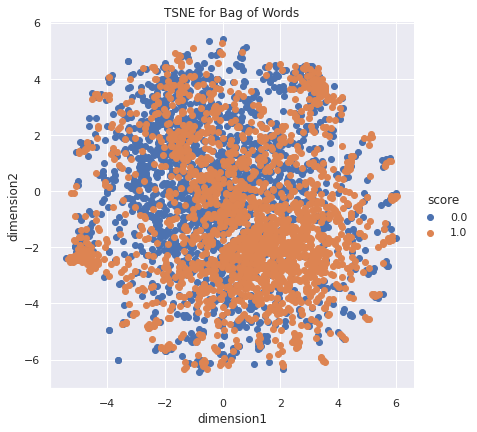

In [ ]:
tsne = TSNE(n_components=2,perplexity=60,n_iter=2500)
tsne_result = tsne.fit_transform(bow_vector)
tsne_new = np.hstack([tsne_result,PDReviews['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

## TFIDF

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely love', 'acceptable', 'accidentally', 'according', 'acid']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4000, 2726)
the number of unique words including both unigrams and bigrams  2726


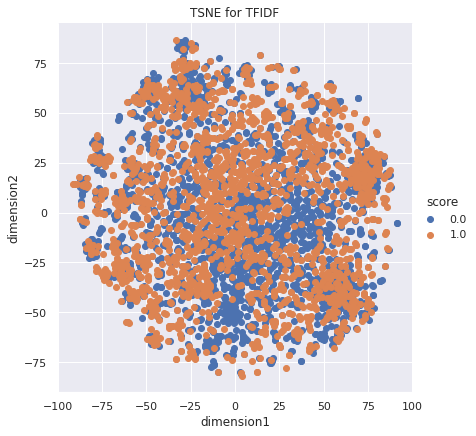

In [ ]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(final_tf_idf)
tsne_new = np.hstack([tsne_result,PDReviews['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for TFIDF")
plt.show()

# Word2Vec

In [ ]:
train_sentence = [rev.split() for rev in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,size=50, workers=4) # use vector_size, if size causes an error
w2v_words = list(w2v_model_train.wv.wv.vocab) # use .index_to_key if .vocab causes an error

## Avg Word2vec

In [ ]:
train_ = train_sentence
sent_vectors_train = []
for sent in tqdm(train_):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 4000/4000 [00:03<00:00, 1051.62it/s]

4000
50


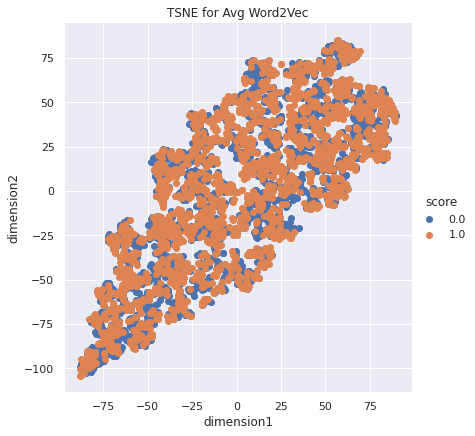

In [ ]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(np.array(sent_vectors_train))
tsne_new = np.hstack([tsne_result,PDReviews['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Avg Word2Vec")
plt.show()

## TFIDF W2v

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(preprocessed_reviews)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

train_sentence = [rev.split() for rev in preprocessed_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])

100%|██████████| 4000/4000 [00:42<00:00, 94.04it/s]

4000
[-0.34432371  0.35626578  0.28366308  0.03404018  0.02332526 -0.03274834
  0.20464698 -0.12337363  0.21550857 -0.01144525  0.12637497  0.10948882
 -0.42420891  0.1982817  -0.2774341  -0.06529691  0.17291211 -0.77222656
 -0.51302589  0.19673095  0.38035203  0.07537462  0.15398208  0.18229794
  0.44926879 -0.51270962 -0.01997955 -0.38666371 -0.02816179  0.59411082
  0.19482786 -0.05678556  0.18901501  0.3142853  -0.23522671 -0.24026632
  0.09953446  0.11918352 -0.17912969  0.12500189 -0.00350101 -0.06346521
  0.1569208  -0.30689957 -0.14709304  0.03432293  0.09738776  0.393828
 -0.31462751  0.41553962]


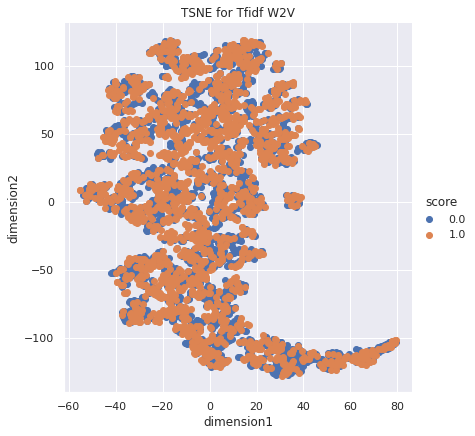

In [ ]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(np.array(sent_vectors_train))
tsne_new = np.hstack([tsne_result,PDReviews['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Tfidf W2V")
plt.show()

###### Steps for TSNE:

* Ran TSNE at different iterations, keeping perplexity constant and found most stable iteration.
* Ran TSNE at diifferent perplexity, with the same iteration  to get a better result.
* After getting a stable result, ran TSNE again with same parameters

###### Observation:
* None of the figures clearly seperate positive and negative reviews

# Machine Learning Model Approach

In [ ]:
Newdf = pd.read_csv('ProcessedRevs.csv')
#one row is empty.we will drop it
Newdf = Newdf.dropna(axis=0)
# #sampling 100k points 
Newdf = Newdf.sample(100000,random_state=100)
#sortimg based on time
Newdf['Time'] = pd.to_datetime(Newdf['Time'],unit='s')
Newdf = Newdf.sort_values('Time')
Newdf = Newdf.reset_index(drop=True)


In [ ]:
#splitting data to train.cv and test
x = Newdf['clean_text']
y = Newdf['Score']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)
X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)

## Bag of words

In [ ]:
bow = CountVectorizer()
bow.fit(X_tr)
X_train_bow = bow.transform(X_tr)
X_cv_bow = bow.transform(X_cv)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_cv_bow is {}'.format(X_cv_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (49000, 42739)
shape of X_cv_bow is (21000, 42739)
shape of X_test_bow is (30000, 42739)


## TFIDF

In [ ]:
#applying bow on x_train and x_test
vectorizer = TfidfVectorizer()
vectorizer.fit(X_tr)
tfidf_features = vectorizer.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_tr)
X_cv_tfidf = vectorizer.transform(X_cv)
X_test_tfidf = vectorizer.transform(X_test)

## Word2Vec

In [ ]:
preprocessed_reviews = X_tr.values
train_sentence = [rev.split() for rev in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model_train = Word2Vec(train_sentence,min_count=5,size=50, workers=4) # use vector_size, if size causes an error
w2v_words = list(w2v_model_train.wv.vocab) # use .index_to_key if .vocab causes an error

## AvgWord2Vec

In [ ]:
train_reviews = X_tr.values
train_sentence = [rev.split() for rev in train_reviews]

sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)

print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

########################################################

cv_reviews = X_cv.values
cv_sentence = [rev.split() for rev in cv_reviews]

sent_vectors_cv = []
for sent in tqdm(cv_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_cv.append(sent_vec)

print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

########################################################
test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]

sent_vectors_test = []
for sent in tqdm(test_sentence):
    count = 0
    sent_vec = np.zeros(50)
    for word in sent:
        if word in w2v_words:
            vector = w2v_model_train.wv[word]
            sent_vec += vector
            count += 1
            
    if count != 0:
        sent_vec /= count
    sent_vectors_test.append(sent_vec)

print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 49000/49000 [01:31<00:00, 534.98it/s]


49000
50


100%|██████████| 21000/21000 [00:39<00:00, 528.98it/s]


21000
50


100%|██████████| 30000/30000 [00:57<00:00, 522.46it/s]

30000
50


## TFIDF Word2Vec

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(X_tr)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

train_reviews = X_tr.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(sent_vectors_train[0])


100%|██████████| 49000/49000 [17:58<00:00, 45.43it/s]

49000
[ 0.17655673  0.58376923 -0.5213177  -0.24759813 -1.62998599  1.58236798
 -0.97921276 -0.18015484  1.54564236  1.37315    -0.75371032  1.62620185
  0.13975035  0.99350149  0.77243284  0.34154487 -0.96148846  1.87951433
 -0.25081297  0.04819778  0.64347576 -0.57044342  0.38329786 -0.15934753
  0.89153583 -1.04083441 -0.38162352  0.96012088 -0.81495175  0.53609295
 -0.69939571  1.13514363  0.24744149  1.05975274 -1.66310666 -0.31146458
  1.67476071  0.51710905  0.66773402  0.48738428 -0.55080129 -0.63114067
 -0.55866864 -1.34151758 -1.46750436 -2.20375611 -0.63989264  1.8999101
  0.78992967  0.02736499]


In [ ]:
cv_reviews = X_cv.values
cv_sentence = [rev.split() for rev in cv_reviews]
sent_vectors_cv = []
for sent in tqdm(cv_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(sent_vectors_cv[0])   

###############################################

test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(sent_vectors_test[0])   

100%|██████████| 21000/21000 [07:39<00:00, 45.68it/s]


21000
[-0.01910554 -0.27997437  0.31062681 -0.73735408 -0.03264687  0.61095718
 -1.13930647  0.98028297 -0.13981747  0.3650077  -1.4397216   0.390661
 -0.68716574 -0.4990668  -1.03622392 -0.02536141 -0.779137   -1.22072032
 -0.883442    0.19253483 -0.15179021  0.13005915 -0.06088796  0.28715071
 -0.1408244  -0.06021977 -1.16409282 -0.64120639 -0.54121424  0.20364044
  0.83456285 -0.37753861  0.36213723 -0.14453208  0.17445362 -0.51635124
 -0.8499163   0.85126023 -0.52557606  0.02790682  0.57798444 -0.01802988
  1.5096922  -0.70568509  1.49608167 -0.35532935 -0.54397342 -0.16908857
  0.61269085  0.66181155]


100%|██████████| 30000/30000 [10:55<00:00, 45.79it/s]

30000
[-1.88594875e-01  5.96552873e-01  7.80701245e-02 -7.84524874e-02
 -2.28520016e-04 -1.34117674e-01 -2.38402051e-01  2.70265530e-01
 -2.30739293e-01  6.68116162e-02  6.01732906e-02  5.66495890e-01
 -5.48557503e-01  4.35797059e-01  6.96982397e-03  2.19590661e-01
 -2.11230255e-02  6.18918700e-02 -3.05437783e-01  3.51683493e-01
  4.33533785e-01  2.65372321e-01 -6.04490169e-01  2.26700021e-01
  3.48558449e-01 -3.60850239e-01 -2.16094246e-02 -4.52109747e-01
 -3.75531380e-01  6.18311648e-01  5.91903684e-01 -1.97110156e-01
  6.49900064e-01  6.60602084e-01 -5.23294698e-01 -3.88175115e-01
  5.84586745e-01 -3.37233100e-02 -3.22551762e-01 -5.11066991e-01
  3.42664669e-01  5.47340020e-01  2.70223806e-01  1.28980507e-01
 -5.07768490e-02 -3.08869284e-01 -3.42531737e-01 -2.87321449e-01
  4.79824382e-01  7.56172601e-01]


In [ ]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
        df = df_train if i==0 else df_test
        sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
        axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
        axes[i].set_xlabel("Predicted Label")
        axes[i].set_ylabel("True Label")
    plt.show()

# Naive Bayes

## Naive Bayes On BagOfWords Features 

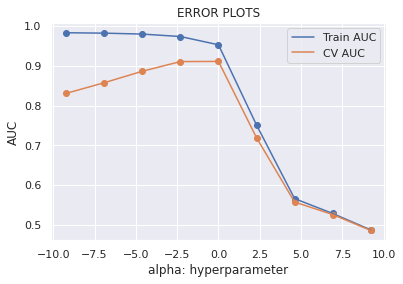

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

train_auc = []
cv_auc = []
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for param in alpha:
    naive = MultinomialNB(alpha=param)
    naive.fit(X_train_bow,y_tr)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    y_train_pred =  naive.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  naive.predict_proba(X_cv_bow)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
#plotting
plt.grid(True)
plt.plot(np.log(alpha), train_auc, label='Train AUC')
plt.plot(np.log(alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(alpha), train_auc)
plt.scatter(np.log(alpha), cv_auc)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

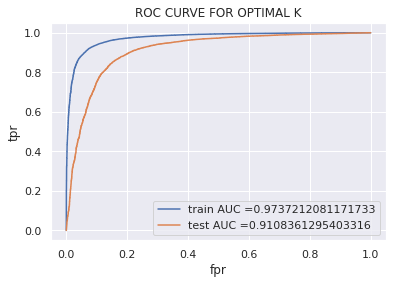

Area under train roc 0.9737212081171733
Area under test roc 0.9108361295403316


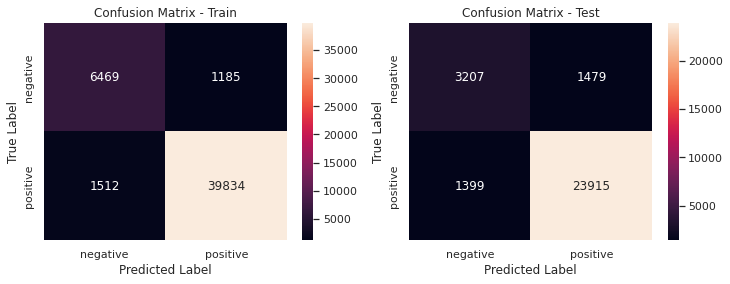

In [ ]:
from sklearn.metrics import roc_curve, auc
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, naive_opt.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(naive_opt,X_train_bow,y_tr,X_test_bow,y_test)

### Feature importance

In [ ]:
data_l = naive_opt.coef_.reshape(-1,1)
features = bow_features
datafr_l = pd.DataFrame(data_l,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                     coef
distortion    -16.588307
braved        -16.588307
onboth        -16.588307
superpump     -16.588307
braun         -16.588307
disappointted -16.588307
disapponting  -16.588307
onethat       -16.588307
housecat      -16.588307
onewanted     -16.588307
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
              coef
not     -3.730610
like    -4.557832
good    -4.669510
great   -4.749963
one     -4.912234
taste   -4.969302
product -5.063838
coffee  -5.071977
flavor  -5.081993
would   -5.101099


# Naive Bayes On TFIDF Features

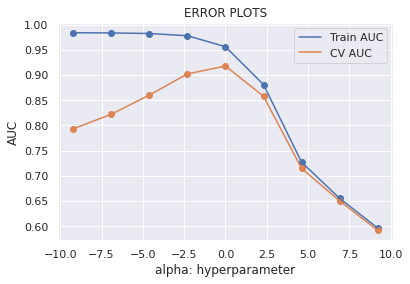

In [ ]:
'''Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

The recipe below evaluates different alpha values for the Ridge Regression algorithm on the dataset. This is a one-dimensional grid search.'''

train_auc = []
cv_auc = []
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for param in alpha:
    naive = MultinomialNB(alpha=param)
    naive.fit(X_train_bow,y_tr)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    y_train_pred =  naive.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred =  naive.predict_proba(X_cv_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_tr,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
#plotting
plt.grid(True)
plt.plot(np.log(alpha), train_auc, label='Train AUC')
plt.plot(np.log(alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(alpha), train_auc)
plt.scatter(np.log(alpha), cv_auc)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

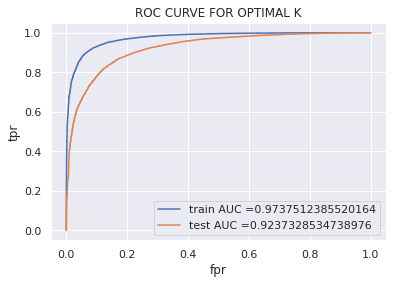

Area under train roc 0.9737512385520164
Area under test roc 0.9237328534738976


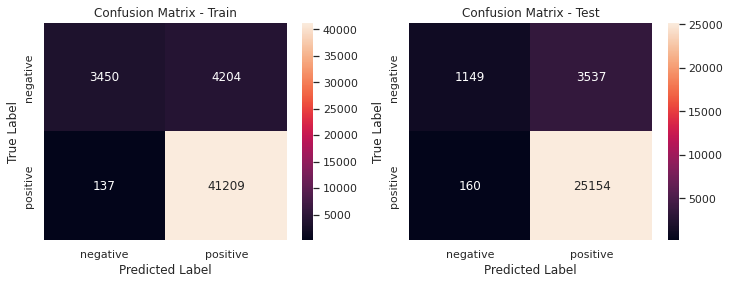

In [ ]:
from sklearn.metrics import roc_curve, auc
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, naive_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(naive_opt,X_train_tfidf,y_tr,X_test_tfidf,y_test)

### Feature importance

In [ ]:
data_l = naive_opt.coef_.reshape(-1,1)
features = tfidf_features
datafr_l = pd.DataFrame(data_l,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                    coef
unforgivable -14.529996
sledge       -14.529996
pervaded     -14.529996
bakesales    -14.529996
disastrous   -14.529996
bakewells    -14.529996
sledgehammer -14.529996
hookworms    -14.529996
baklawa      -14.529996
puk          -14.529996
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
              coef
not     -4.875053
great   -5.179109
good    -5.259509
like    -5.341790
coffee  -5.383004
love    -5.436621
tea     -5.440438
product -5.527242
taste   -5.553319
flavor  -5.592021


## Observations and Conclusions


* Done naive bayes with the earlier bow and tfidf features.
* Even after hyperparamter tuning both models are slightly overfitting.
* Tfidf features model performed slightly better.
* Also got the most important features contributing to each model
* Naive bayes can be considered as a baseline model

In [ ]:
from prettytable import PrettyTable
    
z = PrettyTable()
z.field_names = ["Vector","Algorithm","Hyperparameter-alpha", "Train AUC", "Test AUC"]
z.add_row(["bow","naive-bayes",0.1,0.9737212081171733, 0.9108361295403316])
z.add_row(["tfidf","naive-bayes",0.1,0.9737512385520164,0.9237328534738976])
print(z)


+--------+-------------+----------------------+--------------------+--------------------+
| Vector |  Algorithm  | Hyperparameter-alpha |     Train AUC      |      Test AUC      |
+--------+-------------+----------------------+--------------------+--------------------+
|  bow   | naive-bayes |         0.1          | 0.9737212081171733 | 0.9108361295403316 |
| tfidf  | naive-bayes |         0.1          | 0.9737512385520164 | 0.9237328534738976 |
+--------+-------------+----------------------+--------------------+--------------------+


## Linear SVM

### Loading saved vectors

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [ ]:
# loading bow vectors
X_trainbow = pickle.load(open("X_train_bow","rb"))
X_testbow = pickle.load(open("X_test_bow","rb"))
bow_features = pickle.load(open("bow_features","rb")).tolist()
print('shape of X_trainbow is {}'.format(X_trainbow.shape))
print('shape of X_testbow is {}'.format(X_testbow.shape))


#loading tfidf vectors
X_traintfidf = pickle.load(open("X_train_tfidf","rb"))
X_testtfidf = pickle.load(open("X_test_tfidf","rb"))
tfidf_features = pickle.load(open("tfidf_features","rb")).tolist()
print('shape of X_traintfidf is {}'.format(X_traintfidf.shape))
print('shape of X_testtfidf is {}'.format(X_testtfidf.shape))


w2vwords = pickle.load(open("w2v_words","rb")).tolist()
#avgw2v
X_trainavgw2v = pickle.load(open("X_train_avgw2v","rb"))
X_testavgw2v = pickle.load(open("X_test_avgw2v","rb"))
print('shape of X_trainavgw2v is {}'.format(X_trainavgw2v.shape))
print('shape of X_testavgw2v is {}'.format(X_testavgw2v.shape))


#tfidf-w2v
X_traintfw2v = pickle.load(open("X_train_tfw2v","rb"))
X_testtfw2v = pickle.load(open("X_test_tfw2v","rb"))
print('shape of X_traintfw2v is {}'.format(X_traintfw2v.shape))
print('shape of X_testtfw2v is {}'.format(X_testtfw2v.shape))


y_train = np.load('y_train.npy',allow_pickle=True)
y_test = np.load('y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_trainbow is (70000, 50574)
shape of X_testbow is (30000, 50574)
shape of X_traintfidf is (70000, 50574)
shape of X_testtfidf is (30000, 50574)
shape of X_trainavgw2v is (70000, 50)
shape of X_testavgw2v is (30000, 50)
shape of X_traintfw2v is (70000, 50)
shape of X_testtfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [ ]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
        df = df_train if i==0 else df_test
        sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
        axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
        axes[i].set_xlabel("Predicted Label")
        axes[i].set_ylabel("True Label")
    plt.show()

### Linear SVM On Bow

Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l2'}


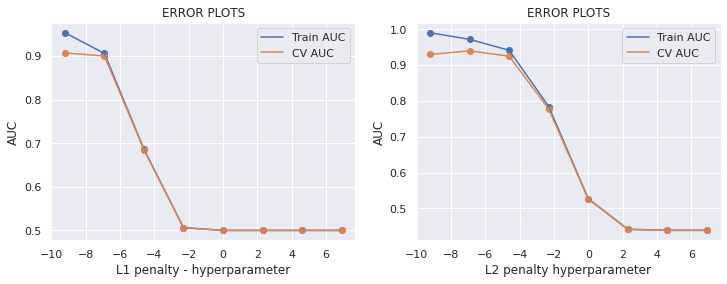

In [ ]:
from sklearn.linear_model import SGDClassifier



Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
    title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
    train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
    cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
    axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
    axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
    axes[i].scatter(np.log(Alpha), train_auc)
    axes[i].grid(True)
    axes[i].legend()
    axes[i].scatter(np.log(Alpha), cv_auc)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel("AUC")
    axes[i].set_title("ERROR PLOTS")

plt.show()

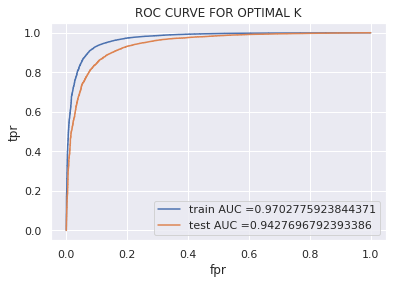

Area under train roc 0.9702775923844371
Area under test roc 0.9427696792393386


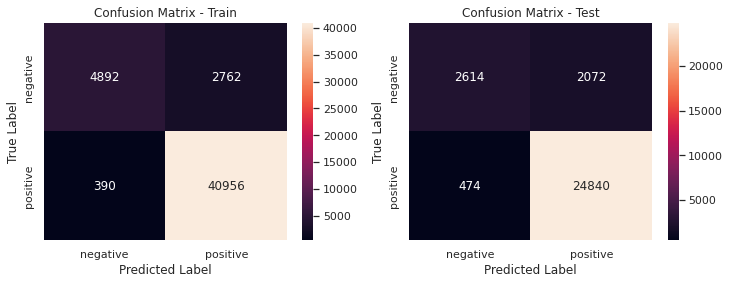

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_bow,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_bow,y_tr,X_test_bow,y_test)

Why use CaliberatedCV?

SVM by default cannot gives the probability of target variables. Use CaliberatedCV to get it as it is used for calculation of our metrics(AUC)

### Linear SVM ON TFIDF

Model with best parameters :
 {'alpha': 0.0001, 'penalty': 'l2'}


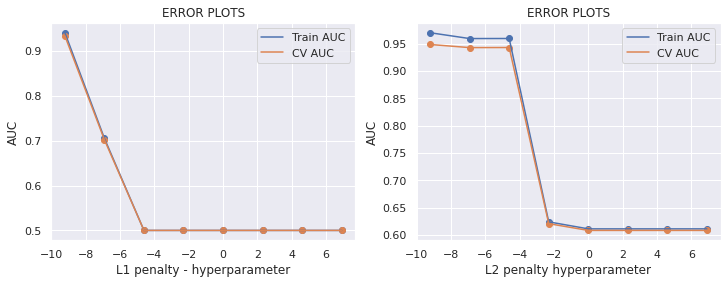

In [ ]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
    title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
    train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
    cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
    axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
    axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
    axes[i].scatter(np.log(Alpha), train_auc)
    axes[i].grid(True)
    axes[i].legend()
    axes[i].scatter(np.log(Alpha), cv_auc)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel("AUC")
    axes[i].set_title("ERROR PLOTS")

plt.show()

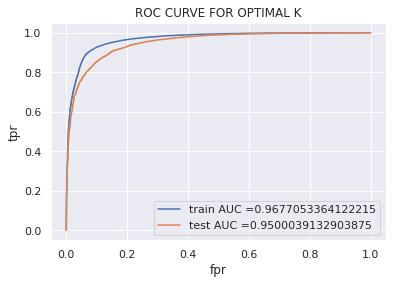

Area under train roc 0.9677053364122215
Area under test roc 0.9500039132903875


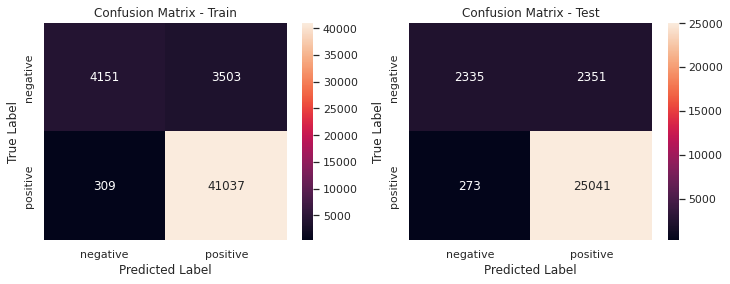

In [ ]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_tfidf,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_tfidf,y_tr,X_test_tfidf,y_test)

### Linear SVM On AVG Word2Vec

Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l2'}


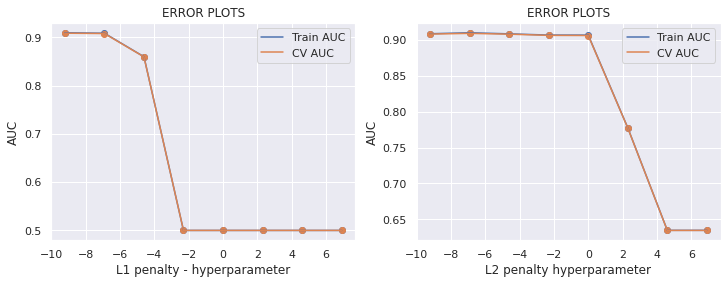

In [ ]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_avgw2v, y_train)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
    title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
    train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
    cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
    axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
    axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
    axes[i].scatter(np.log(Alpha), train_auc)
    axes[i].grid(True)
    axes[i].legend()
    axes[i].scatter(np.log(Alpha), cv_auc)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel("AUC")
    axes[i].set_title("ERROR PLOTS")

plt.show()

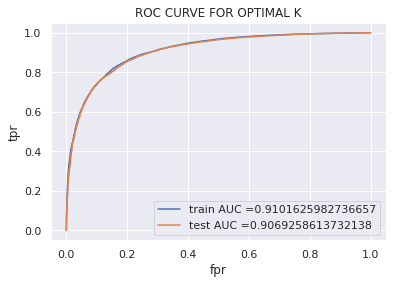

Area under train roc 0.9101625982736657
Area under test roc 0.9069258613732138


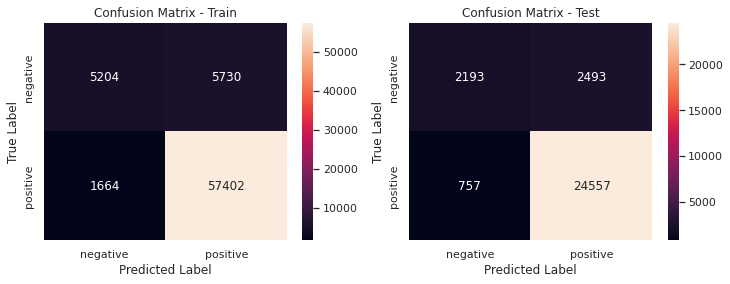

In [ ]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_avgw2v,y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_avgw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_avgw2v,y_train,X_test_avgw2v,y_test)

### Linear SVM On TFIDF - Word2Vec

Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l2'}


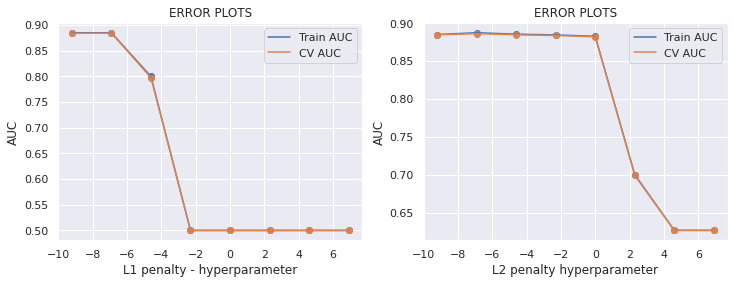

In [ ]:
Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_tfw2v, y_train)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
    title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
    train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
    cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
    axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
    axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
    axes[i].scatter(np.log(Alpha), train_auc)
    axes[i].grid(True)
    axes[i].legend()
    axes[i].scatter(np.log(Alpha), cv_auc)
    axes[i].set_xlabel(title)
    axes[i].set_ylabel("AUC")
    axes[i].set_title("ERROR PLOTS")

plt.show()

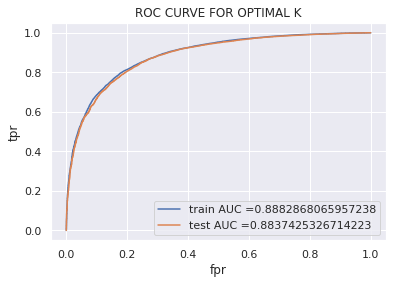

Area under train roc 0.8882868065957238
Area under test roc 0.8837425326714223


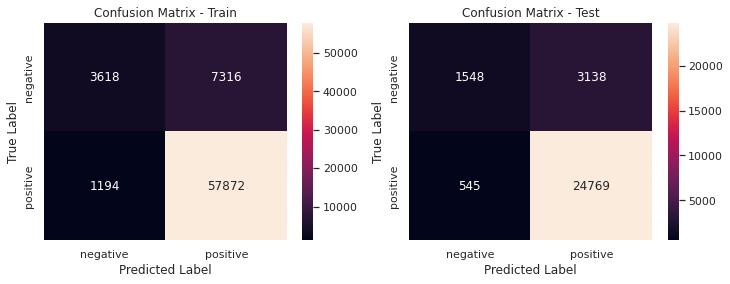

In [ ]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_tfw2v,y_train)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_tfw2v,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_tfw2v,y_train,X_test_tfw2v,y_test)


# Observations and Conclusion

In [4]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","kernel","penalty","Hyperparam-alpha","Hyperparam-C","gamma","Train AUC", "Test AUC"]

z.add_row(["bow","SVM","linear","l2",0.001,"-","-",0.9702775923844371,0.9427696792393386])
z.add_row(["tfidf","SVM","linear","l2",0.0001,"-","-",0.9677053364122215,0.9500039132903875])
z.add_row(["avg-w2v","SVM","linear","l2",0.0001,"-","-",0.9101625982736657,0.9054630562288741])
z.add_row(["tfidf-w2v","SVM","linear","l2",0.001,"-","-",0.8882868065957238,0.9069258613732138])
print(z)

+-----------+-----------+--------+---------+------------------+--------------+-------+--------------------+--------------------+
|   Vector  | Algorithm | kernel | penalty | Hyperparam-alpha | Hyperparam-C | gamma |     Train AUC      |      Test AUC      |
+-----------+-----------+--------+---------+------------------+--------------+-------+--------------------+--------------------+
|    bow    |    SVM    | linear |    l2   |      0.001       |      -       |   -   | 0.9702775923844371 | 0.9427696792393386 |
|   tfidf   |    SVM    | linear |    l2   |      0.0001      |      -       |   -   | 0.9677053364122215 | 0.9500039132903875 |
|  avg-w2v  |    SVM    | linear |    l2   |      0.0001      |      -       |   -   | 0.9101625982736657 | 0.9054630562288741 |
| tfidf-w2v |    SVM    | linear |    l2   |      0.001       |      -       |   -   | 0.8882868065957238 | 0.9069258613732138 |
+-----------+-----------+--------+---------+------------------+--------------+-------+-----------

* SVM performs good with the text data.
* Some of the linear SVM models are slightly overfitting.
* There is a more generalized model with linear SVM on average word2vec vectors.

# Deep Learning Sequence Model

In [ ]:
import bs4
import torch.nn as nn
import torch
import torch.nn.functional as F
import os,re,json
import torch.nn as nn
import shutil
from torch.utils.data import TensorDataset,DataLoader
import gc,time
from sklearn.metrics import roc_auc_score,accuracy_score
from collections import Counter

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.layers import LSTM
from nltk.tokenize.toktok import ToktokTokenizer

In [ ]:
prdreviews = pd.read_csv('ProcessedRevs.csv')
prdreviews = prdreviews.dropna(axis=0)
print(prdreviews.shape)
prdreviews.head()

(363184, 3)


,Time,clean_text,Score
0,1303862400,bought several vitality canned dog food produc...,1
1,1346976000,product arrived labeled jumbo salted peanuts p...,0
2,1219017600,confection around centuries light pillowy citr...,1
3,1307923200,looking secret ingredient robitussin believe f...,0
4,1350777600,great taffy great price wide assortment yummy ...,1


In [ ]:
prdreviews['Time'] = pd.to_datetime(prdreviews['Time'],unit='s')
prdreviews = prdreviews.sort_values('Time')
prdreviews = prdreviews.reset_index(drop=True)
prdreviews.shape

(363184, 3)

In [ ]:
X = prdreviews['clean_text']
y = prdreviews['Score']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (254228,)
shape of X_test is (108956,)
shape of y_train is (254228,)
shape of y_test is (108956,)


In [ ]:
from collections import Counter

# tokenize reviews
tokenizer = ToktokTokenizer()
tokenized_train = [tokenizer.tokenize(text) for text in X_train]
tokenized_test = [tokenizer.tokenize(text) for text in X_test]

#Building word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 95759
Sample slice of vocabulary map: {'school': 11, 'camping': 12, 'etc': 13, 'price': 14, 'reasonable': 15, 'better': 16, 'local': 17, 'grocery': 18, 'stores': 19, 'nothing': 20}


In [ ]:
# get max length of train corpus
max_len = np.max([len(review) for review in tokenized_train])

# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)

print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 1217
Train review vectors shape: (254228, 1217)  Test review vectors shape: (108956, 1217)


In [ ]:
EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="relu"))

model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1217, 128)         12257152  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1217, 128)        0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,306,625
Trainable params: 12,306,625
Non-trainable params: 0
_________________________________________________________________
None


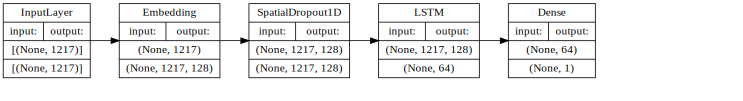

In [ ]:
# Plotting librairies
# from IPython.display import SVG
# import pydot
# import graphviz
# from tensorflow.keras.utils import model_to_dot
# %matplotlib inline
import pydot
import graphviz
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=58).create(prog='dot', format='svg'))

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training and Evaluating the Model

In [ ]:
batch_size = 1200
history = model.fit(train_X, y_train, epochs=5, batch_size=batch_size, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/5
191/191 [==============================] - 749s 4s/step - loss: 0.5220 - accuracy: 0.8120 - val_loss: 0.3520 - val_accuracy: 0.8791
Epoch 2/5
191/191 [==============================] - 743s 4s/step - loss: 0.3030 - accuracy: 0.8948 - val_loss: 0.2646 - val_accuracy: 0.9045
Epoch 3/5
191/191 [==============================] - 742s 4s/step - loss: 0.2472 - accuracy: 0.9155 - val_loss: 0.2424 - val_accuracy: 0.9155
Epoch 4/5
191/191 [==============================] - 741s 4s/step - loss: 0.2381 - accuracy: 0.9174 - val_loss: 0.4773 - val_accuracy: 0.8923
Epoch 5/5
191/191 [==============================] - 741s 4s/step - loss: 0.2679 - accuracy: 0.9104 - val_loss: 0.3499 - val_accuracy: 0.9036


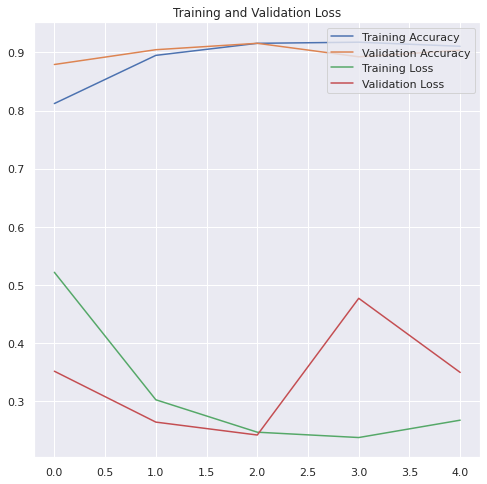

In [ ]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 
epochs_range = range(5) 
plt.figure(figsize=(8, 8)) 
plt.plot(epochs_range, acc, label='Training Accuracy') 
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy') 
plt.plot(epochs_range, loss, label='Training Loss') 
plt.plot(epochs_range, val_loss, label='Validation Loss') 
plt.legend(loc='upper right') 
plt.title('Training and Validation Loss') 
plt.savefig("water_quality_nn.pdf", dpi=100) 
plt.show() 

In [ ]:
pred_test = model.predict(test_X)
pred = [0 if x<=0.5 else 1 for x in pred_test]

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


y_predicted = pred

print("The model accuracy score is: {}".format(accuracy_score(y_test, y_predicted)))
print("The model precision score is: {}".format(precision_score(y_test, y_predicted, average="weighted")))
print("The model recall score is: {}".format(recall_score(y_test, y_predicted, average="weighted")))
print("The model F1-score is: {}".format(f1_score(y_test, y_predicted, average="weighted")))

print(classification_report(y_test, y_predicted))

display(pd.DataFrame(confusion_matrix(y_test, y_predicted), columns=["Pred. negative", "Pred. positive"], index=["Act. negative", "Act. positive"]))

The model accuracy score is: 0.902648775652557
The model precision score is: 0.8986601467328416
The model recall score is: 0.902648775652557
The model F1-score is: 0.890067797667348
              precision    recall  f1-score   support

           0       0.85      0.46      0.60     17097
           1       0.91      0.99      0.94     91859

    accuracy                           0.90    108956
   macro avg       0.88      0.72      0.77    108956
weighted avg       0.90      0.90      0.89    108956



,Pred. negative,Pred. positive
Act. negative,7852,9245
Act. positive,1362,90497


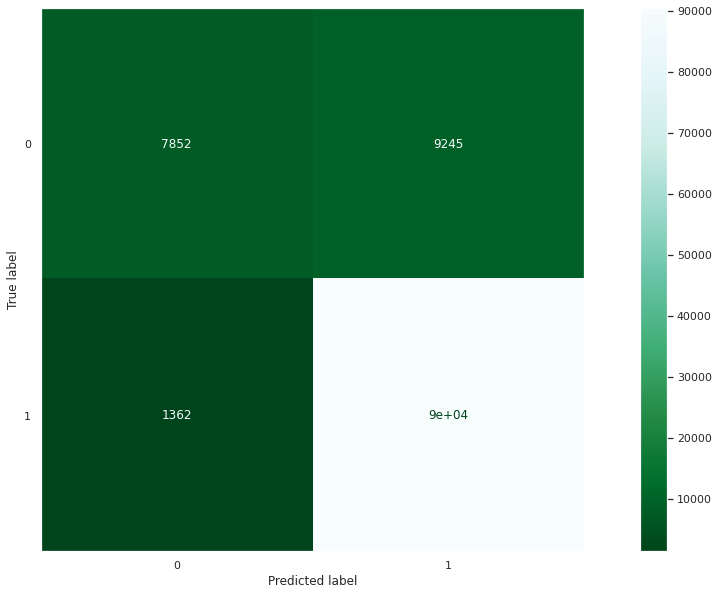

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
sns.set_theme()

f,ax = plt.subplots(1,1,figsize=(20,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, ax=ax, include_values=True, cmap=plt.cm.BuGn_r, xticks_rotation='horizontal', values_format=None, colorbar=True)
plt.grid(False)                  
plt.show()